IMPORTS

The necessary libraries are imported, including tools for data manipulation (pandas), visualization (matplotlib, seaborn), text processing (nltk, re), machine learning models (LogisticRegression, RandomForestClassifier, GaussianNB, LinearSVC), and evaluation metrics.

In [ ]:
# Import necessary libraries
from google.colab import drive
drive.mount("/drive", force_remount=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import STOPWORDS
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

DATA-SET LOAD:

The code uses the loadDataset function to load a hate speech dataset from a CSV file.

In [ ]:
'''
This function is used to get dataset from csv/excel file
Parameters: filename - string represent file path to dataset
'''
def loadDataset(filename):
  return pd.read_csv(filename)

In [ ]:
df = loadDataset('/drive/My Drive/Colab Notebooks/HateSpeech-Dataset.csv')

This dataset is based on Twitter data and was used for hate speech detection research. The text is classified as:

                                                      Hate speech, offensive language, or neither

 It is important to note that due to the nature of the study, this dataset contains text that may be considered racist, sexist, homophobic, or generally offensive. The dataset consist of following details:

1.   index
2.   count - number of CrowdFlower users who coded each tweet
3.   hate_speech - number of CF users who judged the tweet to be hate speech
4.   offensive_language - number of CF users who judged the tweet to be offensive
5.   neither - number of CF users who judged the tweet to be neither offensive nor non-offensive
6.   class - class label for majority of CF users
                                              0 - hate speech 1 - offensive language 2 - neither
7.   tweet - text tweet

DATA-SET INFORMATION:

The getDataInformation function provides information about the dataset, such as its size, shape, columns, data types, missing values, unique values in the 'class' column, and a sample tweet.

In [ ]:
'''
This function is used to get information about shape of dataset
Its column details such as name, type, unique values, number of missing entries
Parameters: df - dataframe consisting dataset
'''
def getDataInformation(df):

  print("                                                           Dataset Information:")
  print("------------------------------------------------------------------------------------------------------------------------------------------------------")

  print(f"\n\nSize of the dataset: {len(df)} rows")

  # get the shape of dataset
  print("\n\nThe shape of dataset is: ", df.shape)

  # get the columns of dataset
  print("\n\nThe columns of dataset are: ", df.columns)

  print("\n\nColumn Information:")
  print(df.info())

  # Display the first few rows of the dataset
  print("\n\nFirst 5 rows of the dataset:")
  print(df.head())

  # Check for missing values
  print("\n\nMissing Values:")
  print(df.isnull().sum())

  # Check unique values in the 'class' column
  print("\n\nUnique Values in 'class' Column:")
  print(df['class'].value_counts())

  # Display a sample tweet
  print("\n\nSample Tweet:")
  print(df['tweet'].iloc[0])

In [ ]:
getDataInformation(df)

                                                           Dataset Information:
------------------------------------------------------------------------------------------------------------------------------------------------------


Size of the dataset: 24783 rows


The shape of dataset is:  (24783, 14)


The columns of dataset are:  Index(['Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3',
       'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'count', 'hate_speech',
       'offensive_language', 'neither', 'class', 'tweet', 'processed_tweets'],
      dtype='object')


Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0.6        24783 non-null  int64 
 1   Unnamed: 0.5        24783 non-null  int64 
 2   Unnamed: 0.4        24783 non-null  int64 
 3   Unnamed: 0.3        24783 non-null  int

DATA PRE-PROCESSING:



The sample tweet present above has hyperlinks, user mentions, blank spaces and punctuations in it. Further analysis of the data needs pre-processing of the tweets to understand the nature of dataset.   

The code preprocesses the text data by removing punctuation, tokenizing, removing stopwords, and stemming. It uses the TextBlob library for sentiment analysis and adds a new column for processed tweets to the dataset.

In [ ]:
## 1. Removal of punctuation and capitalization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming
## 5. Lemmatization

# collecting only the tweets from the csv file into a variable name tweet
tweet=df.tweet

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess(tweet):

    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')

    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")

    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')

    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')

    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')

    # removal of capitalization
    tweet_lower = newtweet.str.lower()

    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())

    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])

    # stemming
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(item) for item in x])

    #lemmatization
    tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(item) for item in x])


    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet

    return tweets_p

processed_tweets = preprocess(tweet)

df['processed_tweets'] = processed_tweets
print(df[["tweet","processed_tweets"]].head(10))
df.to_csv('/drive/My Drive/Colab Notebooks/HateSpeech-Dataset.csv')

<ipython-input-26-6df8b14f95f7>:34: FutureWarning: The default value of regex will change from True to False in a future version.
  punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
<ipython-input-26-6df8b14f95f7>:37: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=punc_remove.str.replace(r'\s+', ' ')
<ipython-input-26-6df8b14f95f7>:40: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
<ipython-input-26-6df8b14f95f7>:43: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')


                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...   
6  !!!!!!"@__BrighterDays: I can not just sit up ...   
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...   
8  " &amp; you might not get ya bitch back &amp; ...   
9  " @rhythmixx_ :hobbies include: fighting Maria...   

                                    processed_tweets  
0  woman complain clean hous amp man alway take t...  
1  boy dat cold tyga dwn bad cuffin dat hoe st place  
2         dawg ever fuck bitch start cri confus shit  
3                                   look like tranni  
4     shit hear might true might faker bitch told ya  
5      shit blow claim faith somebodi still fuck hoe 

EXPLORATORY DATA ANALYSIS:

Various visualizations are generated to explore the dataset, including class distribution, distribution of the number of users who coded each tweet, correlation matrix, word cloud, top words, tweet lengths distribution, distribution of total user ratings, top bi-grams, and sentiment polarity distribution.

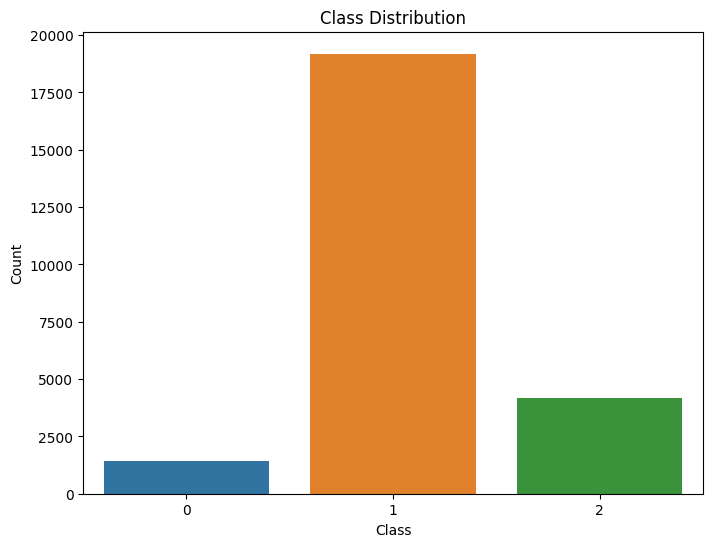

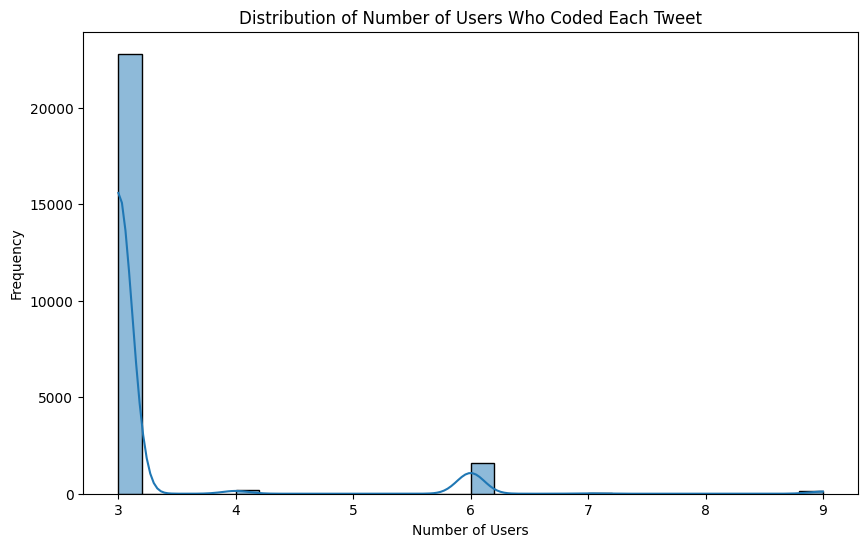

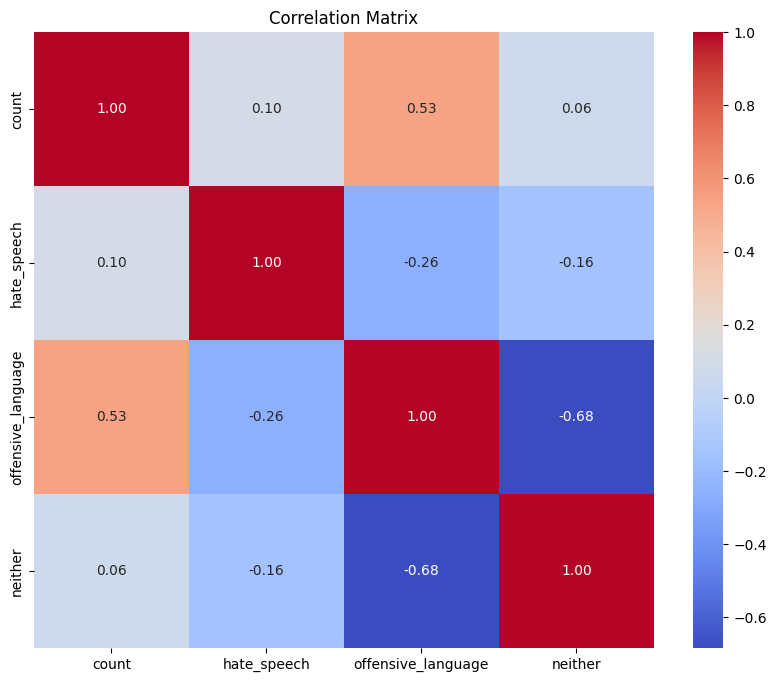

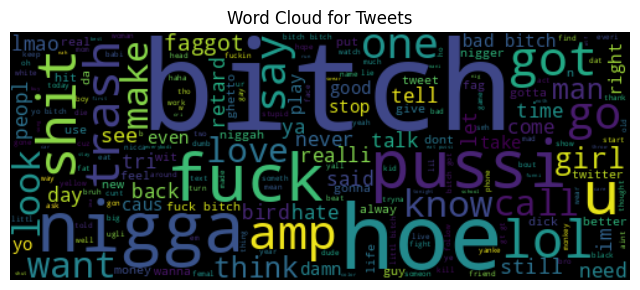

In [ ]:
# Display class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Display the distribution of the number of users who coded each tweet
plt.figure(figsize=(10, 6))
sns.histplot(df['count'], bins=30, kde=True)
plt.title('Distribution of Number of Users Who Coded Each Tweet')
plt.xlabel('Number of Users')
plt.ylabel('Frequency')
plt.show()

# Display correlation matrix
correlation_matrix = df[['count', 'hate_speech', 'offensive_language', 'neither']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

text = ' '.join(df['processed_tweets'])
wordcloud = WordCloud(width=500, height=200, random_state=25, max_font_size=100).generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Tweets')
plt.show()

1. The class 1 - offensive language has more count within the dataset in use.
2. The frequency of the 3 CrowdFlower users who coded each tweet is greater.



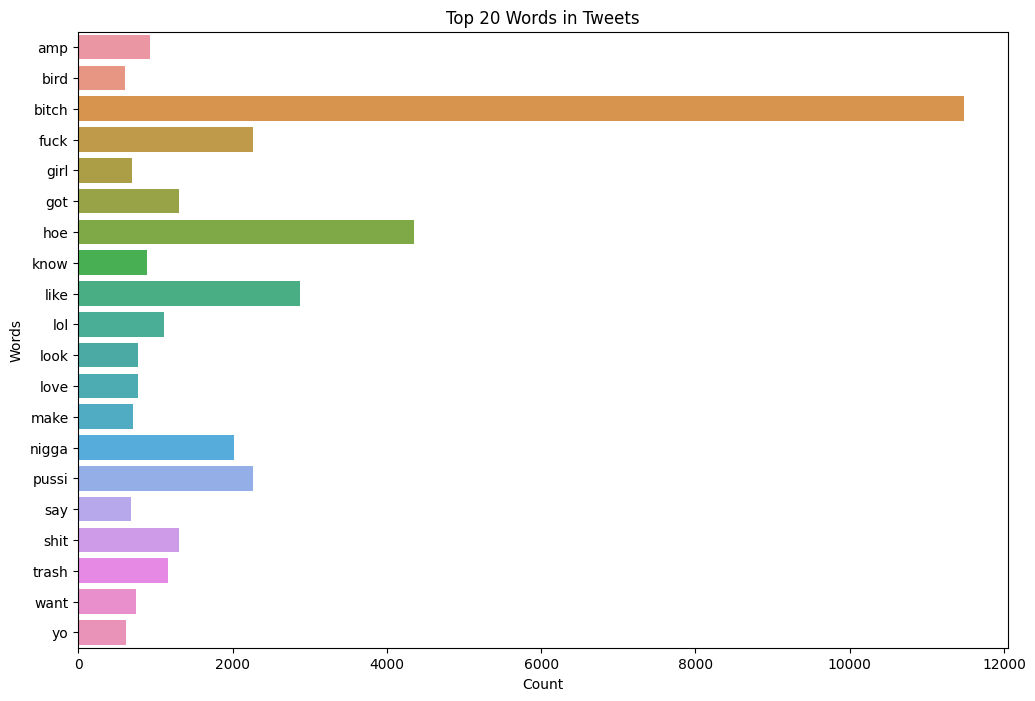

In [ ]:
# Tokenize and count words in tweets
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(df['processed_tweets'])

# Plot the top N words
plt.figure(figsize=(12, 8))
sns.barplot(x=word_counts.sum(axis=0).tolist()[0], y=vectorizer.get_feature_names_out())
plt.title('Top 20 Words in Tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

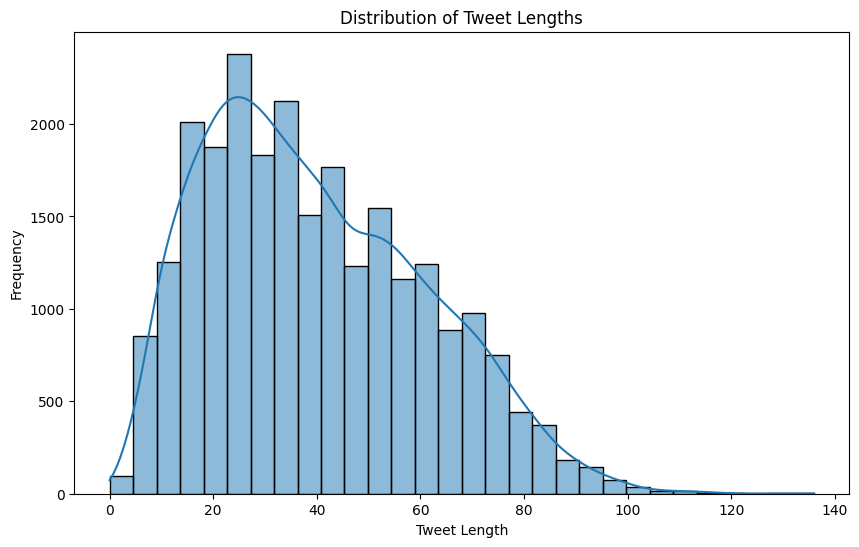

In [ ]:
# Create a new column for tweet lengths
df['tweet_length'] = df['processed_tweets'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

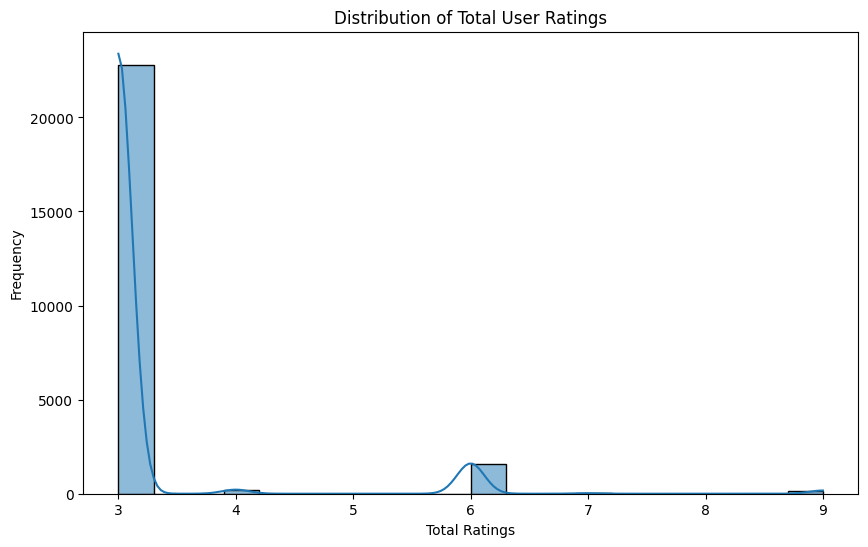

In [ ]:
# Create a new column for the total number of user ratings
df['total_ratings'] = df['hate_speech'] + df['offensive_language'] + df['neither']

# Plot the distribution of total user ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['total_ratings'], bins=20, kde=True)
plt.title('Distribution of Total User Ratings')
plt.xlabel('Total Ratings')
plt.ylabel('Frequency')
plt.show()

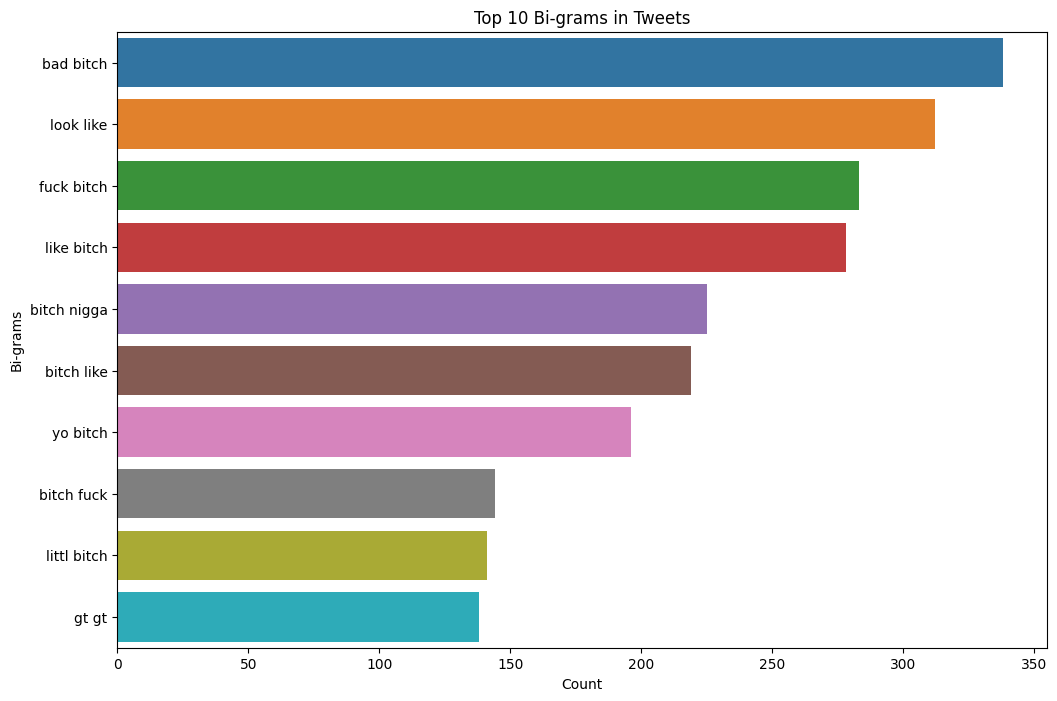

In [ ]:
# Function to get the top N n-grams
def get_top_n_grams(corpus, n=2, top_n=10):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    return words_freq

# Get top 10 bi-grams
top_bi_grams = get_top_n_grams(df['processed_tweets'], n=2, top_n=10)

# Plot top bi-grams
plt.figure(figsize=(12, 8))
sns.barplot(x=[pair[1] for pair in top_bi_grams], y=[pair[0] for pair in top_bi_grams])
plt.title('Top 10 Bi-grams in Tweets')
plt.xlabel('Count')
plt.ylabel('Bi-grams')
plt.show()

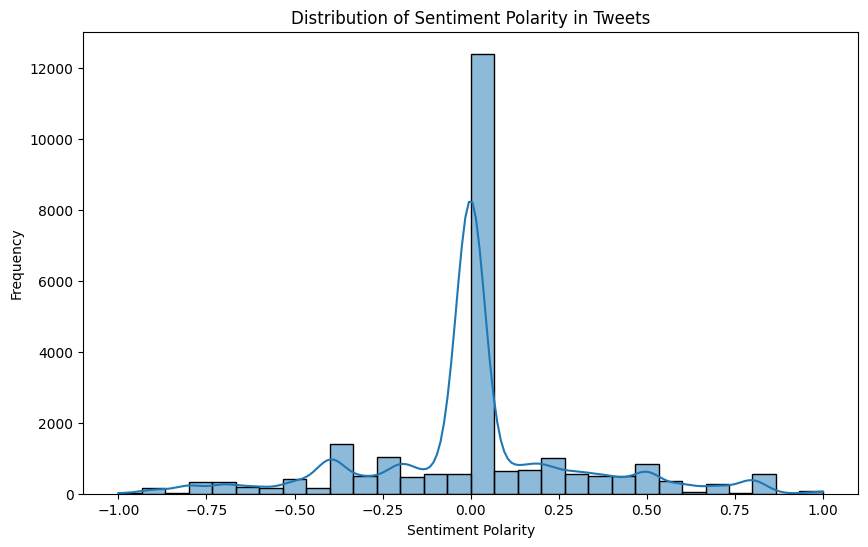

In [ ]:
# Function to get sentiment polarity of a text
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to tweets
df['sentiment_polarity'] = df['processed_tweets'].apply(get_sentiment)

# Plot the distribution of sentiment polarity
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_polarity'], bins=30, kde=True)
plt.title('Distribution of Sentiment Polarity in Tweets')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

MODEL:

1. The code trains and evaluates three machine learning models (Logistic Regression, Naive Bayes, and Support Vector Machine) using TF-IDF features. It also compares the models based on accuracy.

In [ ]:
# TF-IDF Features-F1
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['processed_tweets'] )


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.20      0.27      0.23       290
           1       0.89      0.87      0.88      3832
           2       0.66      0.66      0.66       835

    accuracy                           0.80      4957
   macro avg       0.58      0.60      0.59      4957
weighted avg       0.81      0.80      0.80      4957

Naive Bayes Report:
              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.58      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM Report:
              precision    recall  f1-score   support

           0       0.16      0.27      0.20       290
           1       0.89      0.83      0.86      3832
           2       0.62      0.63      0.63       835

    accuracy                           0.77      4957
   macro avg       0.55      0.58      0.56      4957
weighted avg       0.80      0.77      0.78      4957



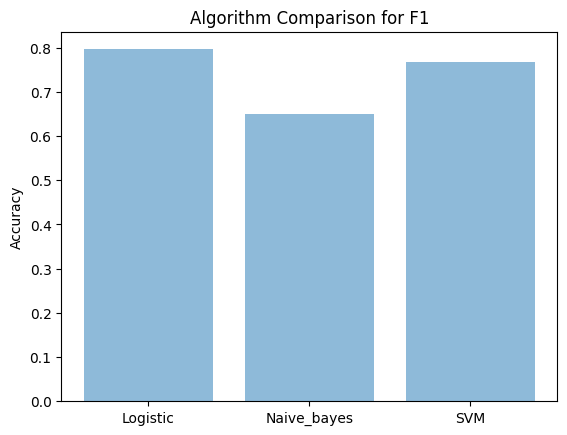

In [ ]:
# Assuming 'tfidf' and 'dataset' are defined
# Logistic Regression
X = tfidf
y = df['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Scale the data (with_mean=False for sparse matrices)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Increase max_iter for Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)
y_preds_logistic = logistic_model.predict(X_test_scaled)
acc_logistic = accuracy_score(y_test, y_preds_logistic)
report_logistic = classification_report(y_test, y_preds_logistic)

print("Logistic Regression Report:")
print(report_logistic)

# Naive Bayes
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train.toarray(), y_train)
y_preds_nb = naive_bayes_model.predict(X_test.toarray())
acc_nb = accuracy_score(y_test, y_preds_nb)
report_nb = classification_report(y_test, y_preds_nb)

print("Naive Bayes Report:")
print(report_nb)

# Support Vector Machine (SVM)
support = LinearSVC(random_state=20) #,max_iter=1000
support.fit(X_train_scaled, y_train)
y_preds_svm = support.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_preds_svm)
report_svm = classification_report(y_test, y_preds_svm)

print("SVM Report:")
print(report_svm)

# Plotting the accuracy comparison
objects = ('Logistic', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc_logistic, acc_nb, acc_svm]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparison for F1')
plt.show()



Logistic Regression appears to have the highest precision, recall, and F1-score, leading to the highest overall accuracy among the three models. Naive Bayes has lower performance, and SVM falls in between the other two models

MODEL:

2. Sentiment analysis using TextBlob is applied to the processed tweets, and the sentiment polarity scores are added as features. The models are then retrained and evaluated with the combined features.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression with Combined Features Report:
              precision    recall  f1-score   support

           0       0.20      0.28      0.23       290
           1       0.89      0.86      0.87      3832
           2       0.63      0.67      0.65       835

    accuracy                           0.79      4957
   macro avg       0.58      0.60      0.59      4957
weighted avg       0.81      0.79      0.80      4957

Naive Bayes with Combined Features Report:
              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.58      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM with Combined Features Report:
              precision    recall  f1-score   support

           0       0.16      0.27      0.20       290
           1       0.89      0.83      0.86      3832
           2       0.61      0.63      0.62       835

    accuracy                           0.77      4957
   macro avg       0.55      0.58      0.56      4957
weighted avg       0.80      0.77      0.78      4957



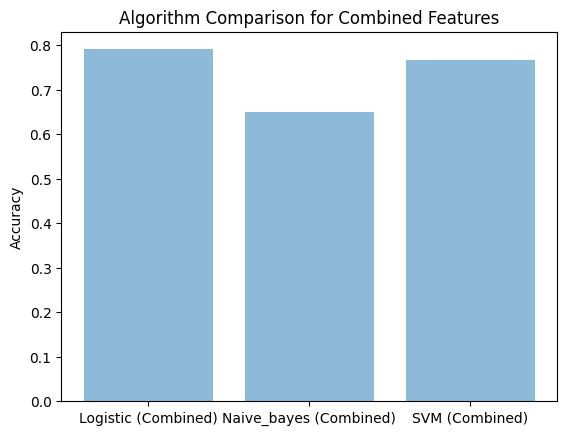

In [ ]:
# Sentiment Analysis using TextBlob and adding polarity scores as features
df['sentiment_polarity'] = df['processed_tweets'].apply(get_sentiment)

# Combine TF-IDF features with sentiment polarity scores
X_combined = np.hstack([tfidf.toarray(), df['sentiment_polarity'].values.reshape(-1, 1)])

# Split the combined features into training and testing sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, y, random_state=42, test_size=0.2
)

# Scale the combined features
scaler_combined = StandardScaler(with_mean=False)
X_train_combined_scaled = scaler_combined.fit_transform(X_train_combined)
X_test_combined_scaled = scaler_combined.transform(X_test_combined)

# Logistic Regression with combined features
logistic_model_combined = LogisticRegression().fit(X_train_combined_scaled, y_train_combined)
y_preds_logistic_combined = logistic_model_combined.predict(X_test_combined_scaled)
acc_logistic_combined = accuracy_score(y_test_combined, y_preds_logistic_combined)
report_logistic_combined = classification_report(y_test_combined, y_preds_logistic_combined)

print("Logistic Regression with Combined Features Report:")
print(report_logistic_combined)

# Naive Bayes with combined features
naive_bayes_model_combined = GaussianNB()
naive_bayes_model_combined.fit(X_train_combined, y_train_combined)
y_preds_nb_combined = naive_bayes_model_combined.predict(X_test_combined)
acc_nb_combined = accuracy_score(y_test_combined, y_preds_nb_combined)
report_nb_combined = classification_report(y_test_combined, y_preds_nb_combined)

print("Naive Bayes with Combined Features Report:")
print(report_nb_combined)

# Support Vector Machine (SVM) with combined features
support_combined = LinearSVC(random_state=20)
support_combined.fit(X_train_combined_scaled, y_train_combined)
y_preds_svm_combined = support_combined.predict(X_test_combined_scaled)
acc_svm_combined = accuracy_score(y_test_combined, y_preds_svm_combined)
report_svm_combined = classification_report(y_test_combined, y_preds_svm_combined)

print("SVM with Combined Features Report:")
print(report_svm_combined)

# Plotting the accuracy comparison for models with combined features
objects_combined = ('Logistic (Combined)', 'Naive_bayes (Combined)', 'SVM (Combined)')
performance_combined = [acc_logistic_combined, acc_nb_combined, acc_svm_combined]

plt.bar(y_pos, performance_combined, align='center', alpha=0.5)
plt.xticks(y_pos, objects_combined)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparison for Combined Features')
plt.show()


For all models, Class 1 has the highest precision, recall, and F1-score, indicating good performance for this class.
Class 0 consistently has lower precision, recall, and F1-score across all models, indicating difficulty in correctly predicting this class.
The overall accuracy for Logistic Regression is the highest (0.79), followed by SVM (0.77) and Naive Bayes (0.65).

MODEL:

3. The code uses Doc2Vec to embed the processed tweets into vectors and combines these vectors with TF-IDF features and sentiment polarity scores. The models are again trained and evaluated with the combined features.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression with Combined Features including Doc2Vec Report:
              precision    recall  f1-score   support

           0       0.21      0.27      0.23       290
           1       0.89      0.87      0.88      3832
           2       0.67      0.67      0.67       835

    accuracy                           0.80      4957
   macro avg       0.59      0.60      0.59      4957
weighted avg       0.81      0.80      0.81      4957

Naive Bayes with Combined Features including Doc2Vec Report:
              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.58      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM with Combined Features including Doc2Vec Report:
              precision    recall  f1-score   support

           0       0.18      0.29      0.22       290
           1       0.89      0.84      0.86      3832
           2       0.61      0.64      0.63       835

    accuracy                           0.77      4957
   macro avg       0.56      0.59      0.57      4957
weighted avg       0.80      0.77      0.79      4957



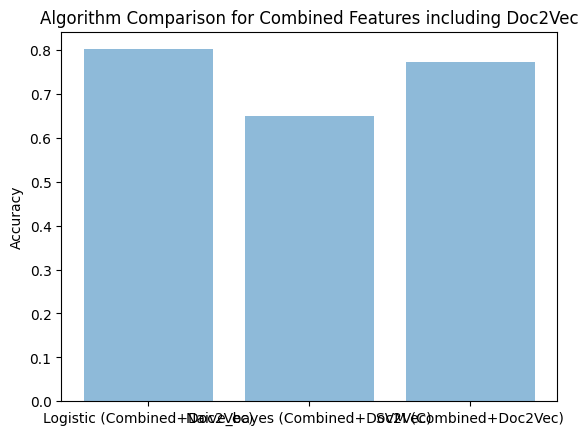

In [ ]:
# Tokenize the processed tweets
tokenized_tweets = df['processed_tweets'].apply(lambda x: x.split())

# Create TaggedDocuments for Doc2Vec training
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(tokenized_tweets)]

# Initialize and train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=10)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Function to get Doc2Vec vectors for a given set of words
def get_doc2vec_vector(words):
    return doc2vec_model.infer_vector(words)

# Add Doc2Vec vector columns to the dataset
df['doc2vec_vector'] = tokenized_tweets.apply(get_doc2vec_vector)

# Combine TF-IDF features with sentiment polarity scores and Doc2Vec vectors
X_combined_doc2vec = np.hstack([tfidf.toarray(), df['sentiment_polarity'].values.reshape(-1, 1),
                                np.vstack(df['doc2vec_vector'].to_numpy())])

# Split the combined features into training and testing sets
X_train_combined_doc2vec, X_test_combined_doc2vec, y_train_combined_doc2vec, y_test_combined_doc2vec = train_test_split(
    X_combined_doc2vec, y, random_state=42, test_size=0.2
)

# Scale the combined features
scaler_combined_doc2vec = StandardScaler(with_mean=False)
X_train_combined_scaled_doc2vec = scaler_combined_doc2vec.fit_transform(X_train_combined_doc2vec)
X_test_combined_scaled_doc2vec = scaler_combined_doc2vec.transform(X_test_combined_doc2vec)

# Logistic Regression with combined features including Doc2Vec
logistic_model_combined_doc2vec = LogisticRegression().fit(X_train_combined_scaled_doc2vec, y_train_combined_doc2vec)
y_preds_logistic_combined_doc2vec = logistic_model_combined_doc2vec.predict(X_test_combined_scaled_doc2vec)
acc_logistic_combined_doc2vec = accuracy_score(y_test_combined_doc2vec, y_preds_logistic_combined_doc2vec)
report_logistic_combined_doc2vec = classification_report(y_test_combined_doc2vec, y_preds_logistic_combined_doc2vec)

print("Logistic Regression with Combined Features including Doc2Vec Report:")
print(report_logistic_combined_doc2vec)

# Naive Bayes with combined features including Doc2Vec
naive_bayes_model_combined_doc2vec = GaussianNB()
naive_bayes_model_combined_doc2vec.fit(X_train_combined_doc2vec, y_train_combined_doc2vec)
y_preds_nb_combined_doc2vec = naive_bayes_model_combined_doc2vec.predict(X_test_combined_doc2vec)
acc_nb_combined_doc2vec = accuracy_score(y_test_combined_doc2vec, y_preds_nb_combined_doc2vec)
report_nb_combined_doc2vec = classification_report(y_test_combined_doc2vec, y_preds_nb_combined_doc2vec)

print("Naive Bayes with Combined Features including Doc2Vec Report:")
print(report_nb_combined_doc2vec)

# Support Vector Machine (SVM) with combined features including Doc2Vec
support_combined_doc2vec = LinearSVC(random_state=20)
support_combined_doc2vec.fit(X_train_combined_scaled_doc2vec, y_train_combined_doc2vec)
y_preds_svm_combined_doc2vec = support_combined_doc2vec.predict(X_test_combined_scaled_doc2vec)
acc_svm_combined_doc2vec = accuracy_score(y_test_combined_doc2vec, y_preds_svm_combined_doc2vec)
report_svm_combined_doc2vec = classification_report(y_test_combined_doc2vec, y_preds_svm_combined_doc2vec)

print("SVM with Combined Features including Doc2Vec Report:")
print(report_svm_combined_doc2vec)

# Plotting the accuracy comparison for models with combined features including Doc2Vec
objects_combined_doc2vec = ('Logistic (Combined+Doc2Vec)', 'Naive_bayes (Combined+Doc2Vec)', 'SVM (Combined+Doc2Vec)')
performance_combined_doc2vec = [acc_logistic_combined_doc2vec, acc_nb_combined_doc2vec, acc_svm_combined_doc2vec]

plt.bar(y_pos, performance_combined_doc2vec, align='center', alpha=0.5)
plt.xticks(y_pos, objects_combined_doc2vec)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparison for Combined Features including Doc2Vec')
plt.show()


Logistic Regression:

    Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. For class 0, it's 0.21; for class 1, it's 0.89; and for class 2, it's 0.67.
    Recall: Recall (Sensitivity or True Positive Rate) is the ratio of correctly predicted positive observations to the all observations in actual class. For class 0, it's 0.27; for class 1, it's 0.87; and for class 2, it's 0.67.
    F1-Score: F1-Score is the weighted average of Precision and Recall. For class 0, it's 0.23; for class 1, it's 0.88; and for class 2, it's 0.67.
    Accuracy: Overall accuracy of the model is 0.80, indicating that 80% of the predictions are correct.

Naive Bayes:

    Precision: For class 0, it's 0.10; for class 1, it's 0.89; and for class 2, it's 0.54.
    Recall: For class 0, it's 0.39; for class 1, it's 0.68; and for class 2, it's 0.58.
    F1-Score: For class 0, it's 0.16; for class 1, it's 0.77; and for class 2, it's 0.56.
    Accuracy: Overall accuracy is 0.65, indicating that 65% of the predictions are correct.

SVM:

    Precision: For class 0, it's 0.18; for class 1, it's 0.89; and for class 2, it's 0.61.
    Recall: For class 0, it's 0.29; for class 1, it's 0.84; and for class 2, it's 0.64.
    F1-Score: For class 0, it's 0.22; for class 1, it's 0.86; and for class 2, it's 0.63.
    Accuracy: Overall accuracy is 0.77, indicating that 77% of the predictions are correct.

INTERPRETATION OF RESULTS:

The code includes functions for plotting confusion matrices, feature importance, and ROC curves. Confusion matrices are displayed using ConfusionMatrixDisplay, and feature importance is visualized for Logistic Regression and SVM.

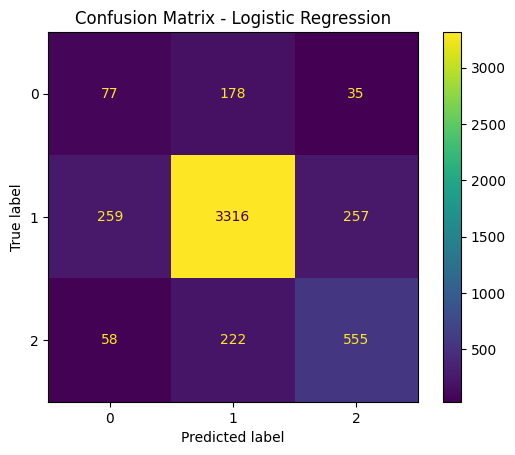

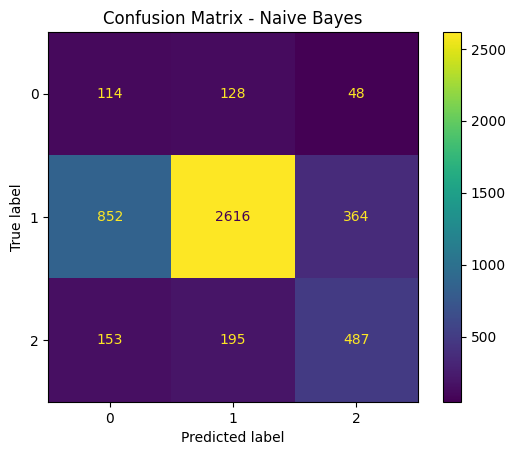

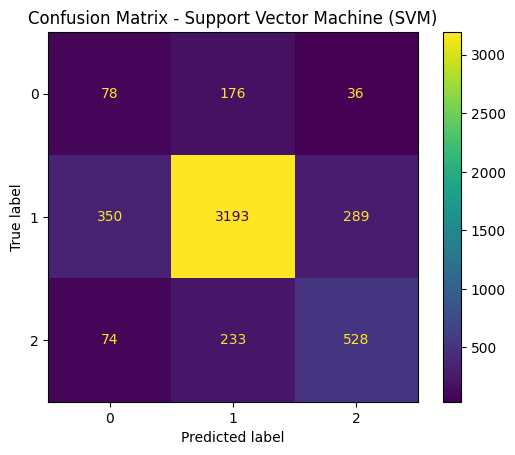

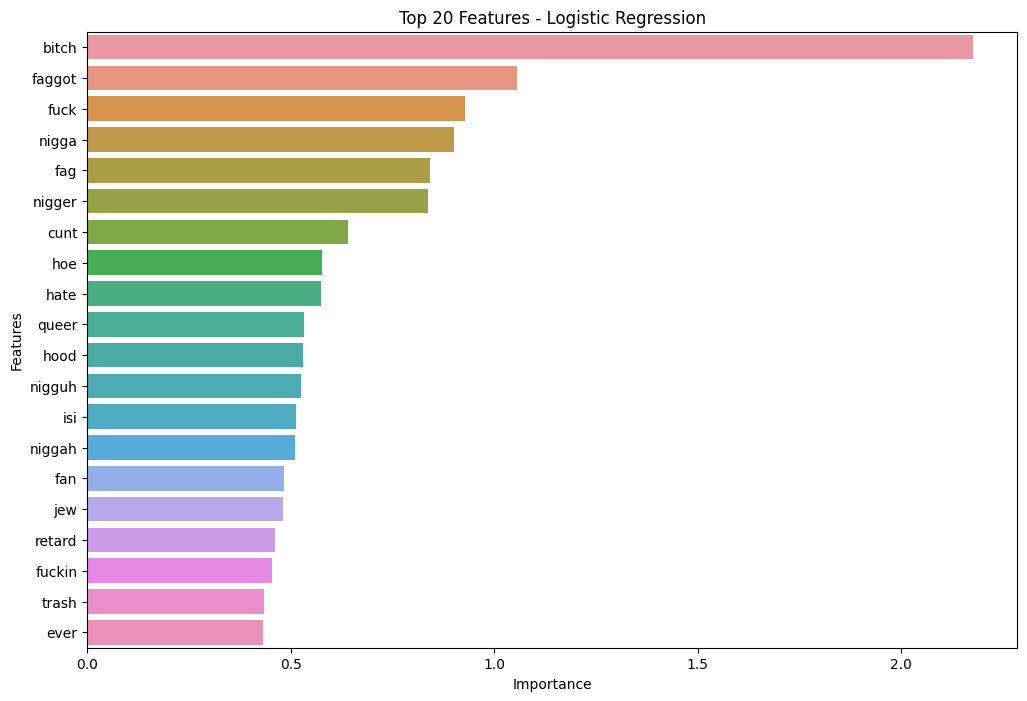

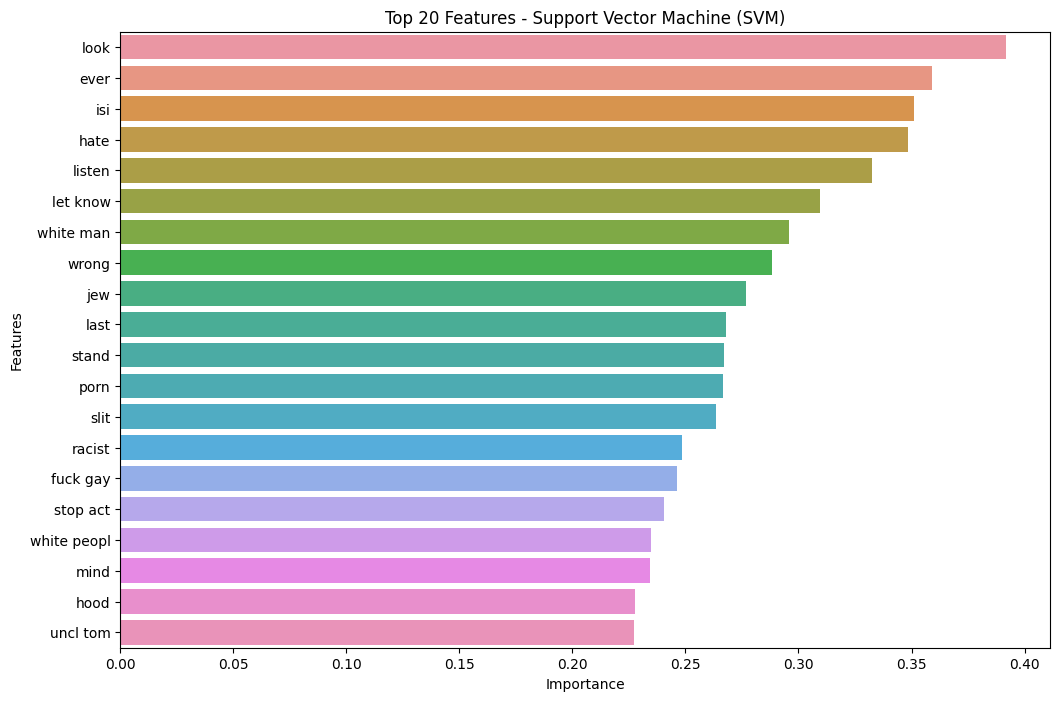

In [ ]:
# Function to plot confusion matrix using ConfusionMatrixDisplay
def plot_confusion(model, X_test, y_test, model_name):
    y_preds = model.predict(X_test)
    confusion_matrix_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['0', '1', '2'])
    plt.title(f'Confusion Matrix - {model_name}')

# Logistic Regression
plot_confusion(logistic_model, X_test_scaled, y_test, 'Logistic Regression')

# Naive Bayes
plot_confusion(naive_bayes_model, X_test.toarray(), y_test, 'Naive Bayes')

# SVM
plot_confusion(support, X_test_scaled, y_test, 'Support Vector Machine (SVM)')

# Feature Importance (for Logistic Regression and SVM)
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'coef_'):
        importance = model.coef_[0]
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        print(f"Feature importance not available for {model_name}.")
        return

    feature_importance = pd.DataFrame(importance, index=feature_names, columns=['importance'])
    sorted_feature_importance = feature_importance.sort_values(by='importance', ascending=False)

    # Plot the top N features
    top_n = 20
    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_feature_importance['importance'][:top_n], y=sorted_feature_importance.index[:top_n])
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

# Plot feature importance for Logistic Regression
plot_feature_importance(logistic_model, tfidf_vectorizer.get_feature_names_out(), 'Logistic Regression')

# Plot feature importance for SVM
plot_feature_importance(support, tfidf_vectorizer.get_feature_names_out(), 'Support Vector Machine (SVM)')

# ... (Continue with other interpretations as per your needs)

plt.show()  # Ensure all plots are displayed at once


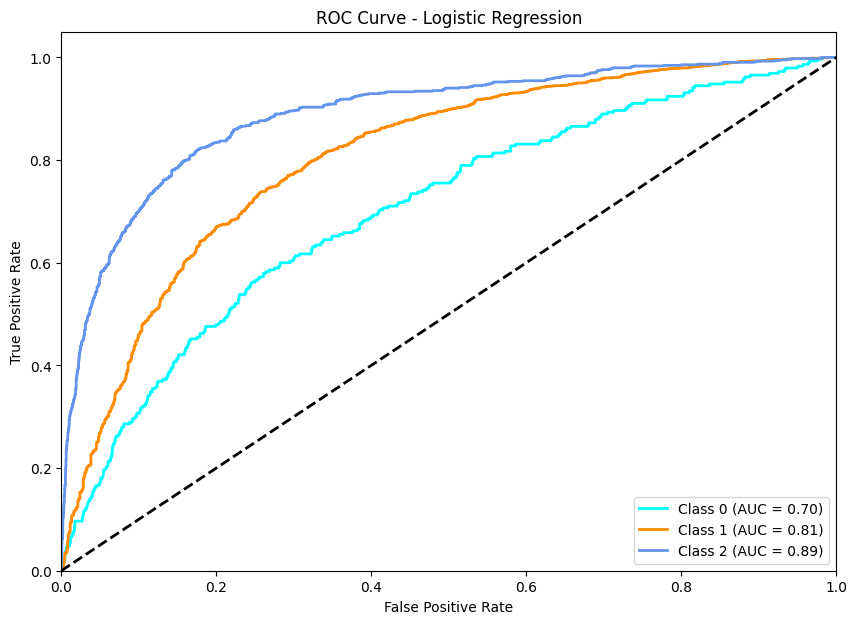

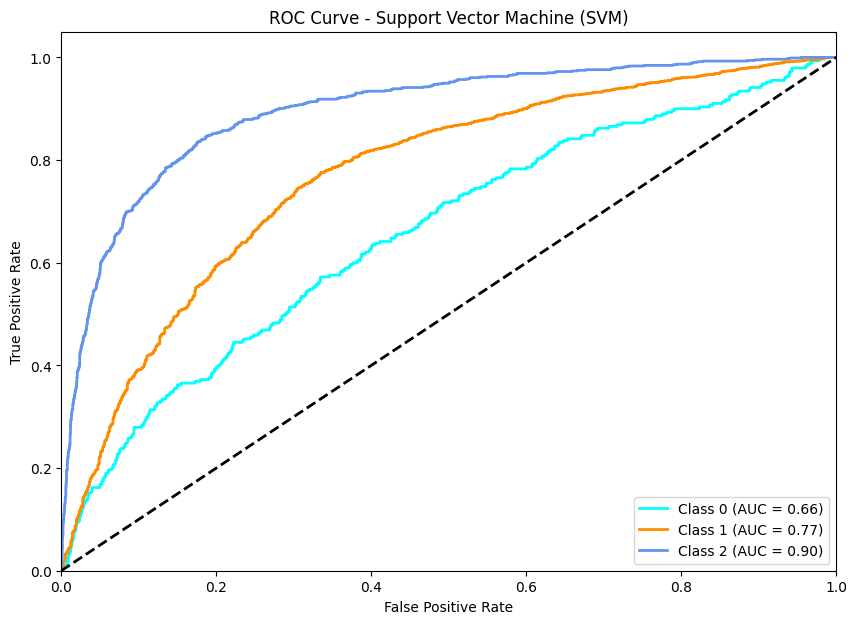

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(model, X_test, y_test, n_classes, model_name):
    y_score = model.decision_function(X_test)

    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure(figsize=(10, 7))
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve for Logistic Regression
plot_roc_curve(logistic_model, X_test_scaled, y_test, n_classes=3, model_name='Logistic Regression')

# Plot ROC curve for SVM
plot_roc_curve(support, X_test_scaled, y_test, n_classes=3, model_name='Support Vector Machine (SVM)')

plt.show()  # Ensure all plots are displayed at once


Logistic Regression:

    Class 0 (AUC = 0.70): The AUC for class 0 is 0.70, which is between 0.5 and 1. This suggests that the model is better than random guessing for classifying instances of class 0. However, the discriminative power is moderate.
    Class 1 (AUC = 0.81):The AUC for class 1 is 0.81, indicating a better discriminative ability compared to class 0. The model is relatively good at distinguishing between class 1 instances and the rest.
    Class 2 (AUC = 0.89):The AUC for class 2 is 0.89, which is the highest among the three classes. This suggests that the model performs very well in distinguishing between class 2 instances and the rest.


SVM:

    Class 0 - AUC 0.66:The AUC for Class 0 is 0.66, which is between 0.5 and 1. This suggests that the classifier has some ability to distinguish Class 0 from the rest, but the discrimination is not very strong.
    Class 1 - AUC 0.77:The AUC for Class 1 is 0.77, indicating a better discriminatory ability compared to Class 0. The classifier is relatively more effective at distinguishing Class 1 from the other classes.
    Class 2 - AUC 0.90:The AUC for Class 2 is 0.90, which is relatively high. This suggests that the classifier performs well in distinguishing Class 2 from the other classes. A higher AUC indicates a strong ability to separate Class 2 instances from the rest.